In [1]:
%load_ext autoreload
%autoreload 2
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
root = '/home/bzr0014/Additive/'

In [2]:
!ls {root}files

April26_AMboneA1_volume_abs.h5	       low_transformed.np
April26_AMboneA1_volume_absorption.h5  mardas.model
April26_AMboneA1_volume_darkfield.h5   model20200216.keras
April27_AMA2_volume_abs.h5	       model20200225.keras
April27_AMA2_volume_darkfield.h5       model20200226_2.keras
high_3d.np			       model20200226_3.keras
high_transformed.np		       model20200226.keras
low_3d_dark.np			       resize.py
low_3d.np			       to_use_in_ml.np
low_transformed_dark.np


In [3]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
import h5py
from joblib import load, dump
from sklearn.cluster import KMeans
from dask.distributed import LocalCluster, Client
from additive2 import utility
from additive2.config import *
import glob
from multiprocessing import Pool
from dask import compute, delayed
from additive2.utility import min_max_scale
from scipy.ndimage import zoom
import imageio

In [ ]:
# cluster = LocalCluster(n_workers=6, threads_per_worker=1)
# client = Client(cluster)
# client

In [8]:
low_transformed = load(root+'files/low_transformed.np')
high_transformed = load(root+'files/high_transformed.np')

In [9]:
low_transformed.shape, high_transformed.shape

((158, 162, 166), (158, 162, 166))

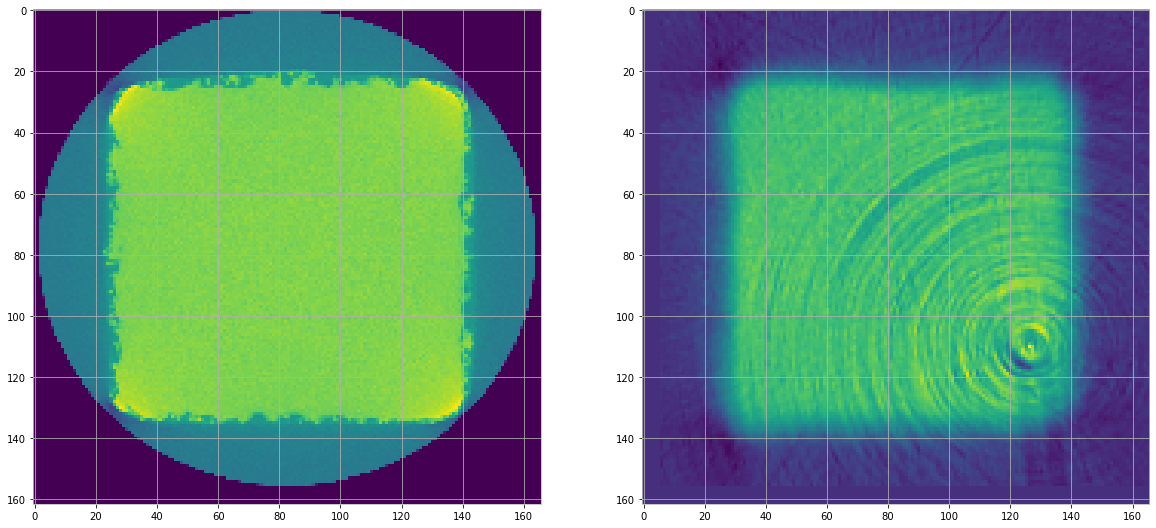

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(high_transformed[10])
axes[1].imshow(low_transformed[10])

In [11]:
from IPython.display import clear_output
import time
for i in reversed(range(110, 130)):
    try:
        fig, axes = plt.subplots(1, 2, figsize=(30, 15))
        axes[0].imshow(high_transformed[:, i, :])
        axes[1].imshow(low_transformed[:, i, :])
        axes[0].set_title(f"{i}")
        axes[1].set_title(f"{i}")
        plt.show()
        clear_output(True)
        time.sleep(.3)
    except KeyboardInterrupt:
        stop = input("stop? ")
        if stop.lower() == 'y':
            break

stop? y


<Figure size 2160x1080 with 0 Axes>

In [4]:
super_high_res_files = glob.glob("/home/bzr0014/Additive/LSU_NonHIP/0.7um/*tiff")
high_res_files = glob.glob("/home/bzr0014/Additive/LSU_NonHIP/2.9um/*tiff")

In [11]:
import imageio
super_high_res_file = np.random.choice(super_high_res_files)
high_res_file = np.random.choice(high_res_files)
print(super_high_res_file)
super_high_res_img = imageio.imread(super_high_res_file)
high_res_img = imageio.imread(high_res_file)

/home/bzr0014/Additive/LSU_NonHIP/0.7um/LSU_DogboneNonHIP_0.7um_0359.tiff


In [12]:
resize_factor = .3
w, h = super_high_res_img.shape
new_shape = int(h*.7 * resize_factor), int(w*.7 * resize_factor)
resized_super_high_img = cv2.resize(super_high_res_img, new_shape)

In [13]:
w, h = high_res_img.shape
new_shape = int(h*2.9 * resize_factor), int(w*2.9 * resize_factor)
resized_high_img = cv2.resize(high_res_img, new_shape)

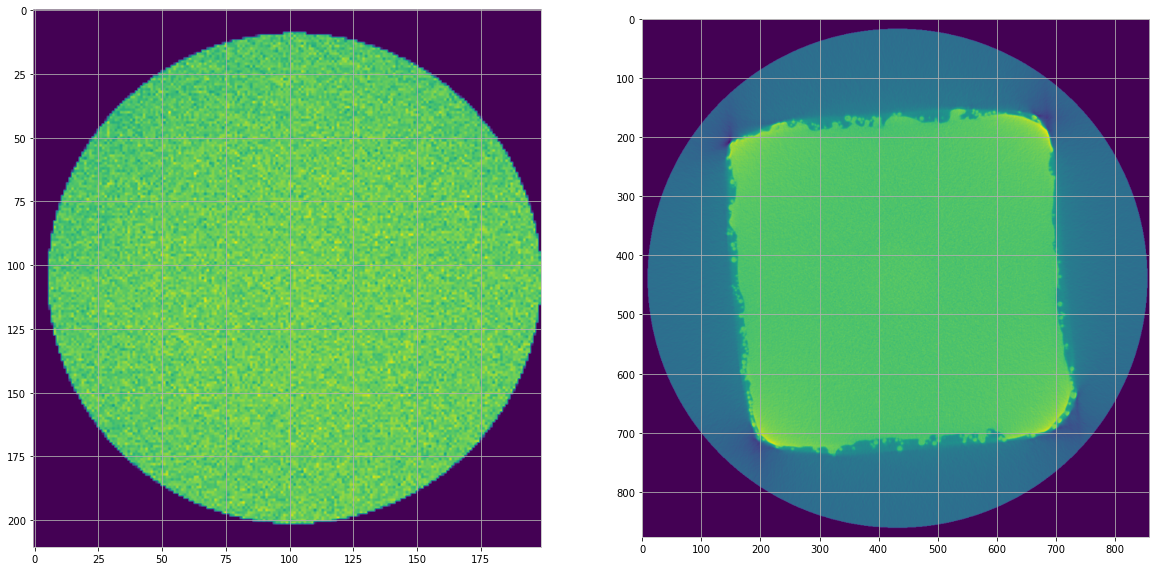

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(resized_super_high_img)
axes[1].imshow(resized_high_img)

In [17]:
from typing import Iterable
from itertools import count
from IPython.display import clear_output
def show_image_list(images: Iterable[np.ndarray], titles=None, sleep_time=1, figsize=(10, 10), 
                    start_title_index=0):
    if titles is None:
        titles = count(start_title_index)
    for title, image in zip(titles, images):
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(image)
        ax.set_title(title)
        plt.show()
        time.sleep(sleep_time)
        clear_output(True)

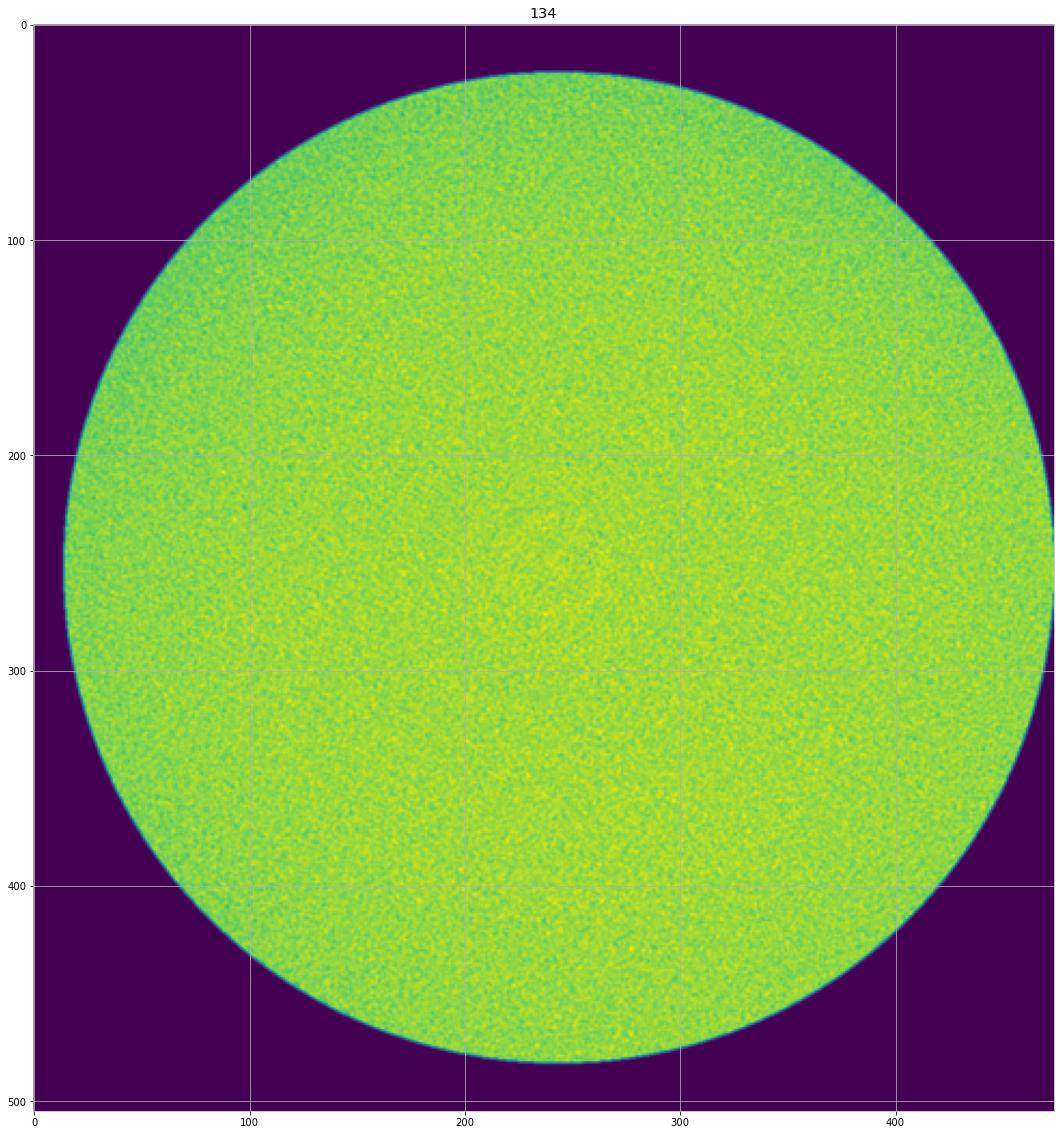

KeyboardInterrupt: 

In [214]:
sleep_time = .5
start_index = 68
end_index = -1
show_image_list(
    (cv2.pyrDown(imageio.imread(x)) for x in super_high_res_files[start_index:end_index]), 
    sleep_time=sleep_time,  figsize=(20, 20), start_title_index=start_index
)

In [155]:
sleep_time = 1
start_index, end_index = 200, 700
show_image_list(
    (imageio.imread(x)[200:800, 200:800] for x in high_res_files[start_index:end_index]), 
    sleep_time=sleep_time,  figsize=(15, 15), start_title_index=start_index
)

KeyboardInterrupt: 

<Figure size 1080x1080 with 0 Axes>

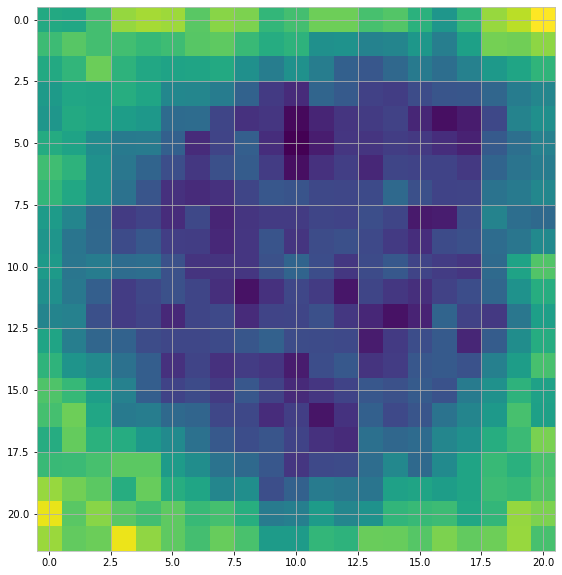

In [96]:
plt.imshow(imageio.imread(super_high_res_files[68])[573:595, 786:807]

In [47]:
(183-68)*.7/2.9 + 231

258.7586206896552

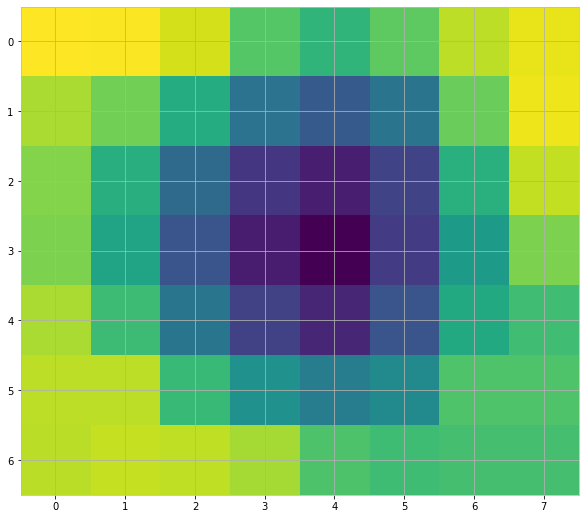

In [93]:
plt.imshow(imageio.imread(high_res_files[230])[480:487, 547:555])

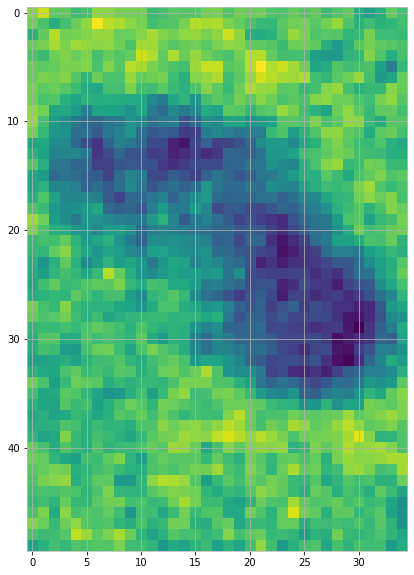

In [38]:
plt.imshow(imageio.imread(super_high_res_files[183])[890:940, 485:520])

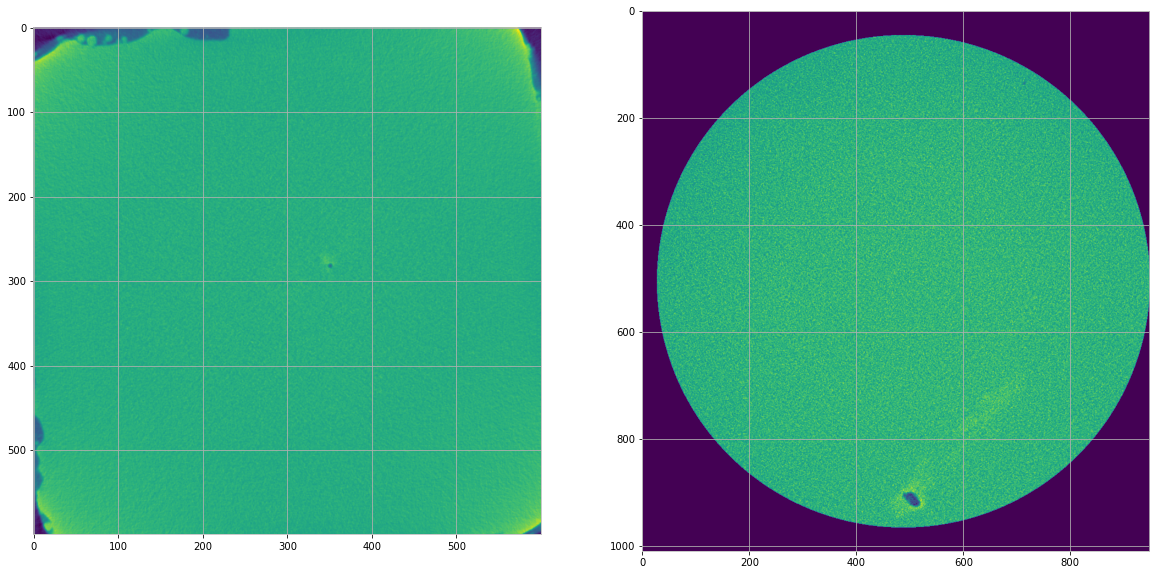

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(imageio.imread(high_res_files[230])[200:800, 200:800])
axes[1].imshow(imageio.imread(super_high_res_files[724]))

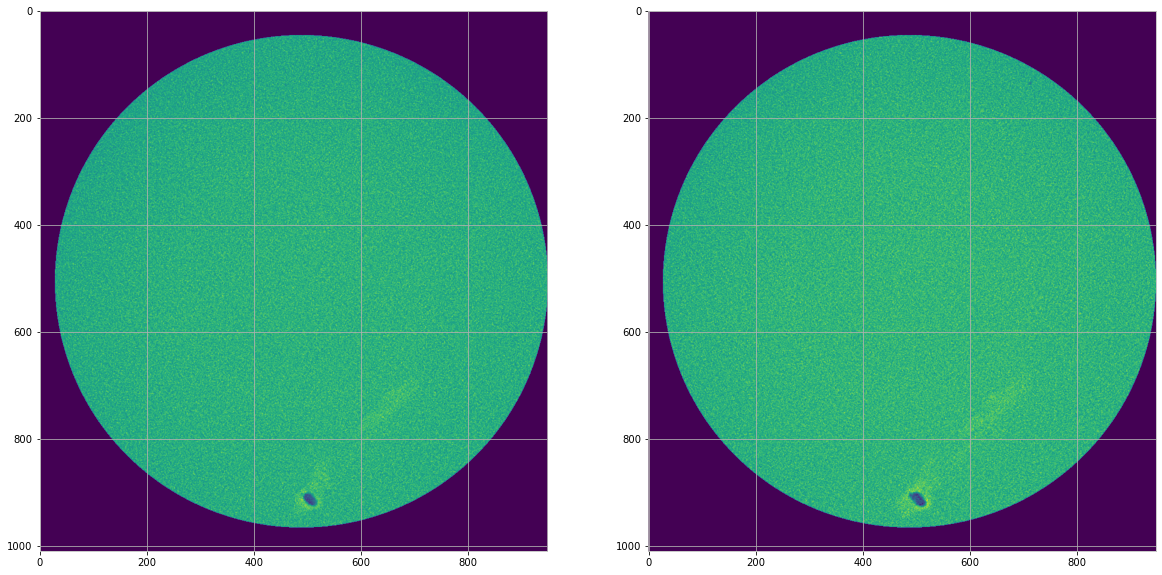

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(imageio.imread(super_high_res_files[508]))
axes[1].imshow(imageio.imread(super_high_res_files[724]))

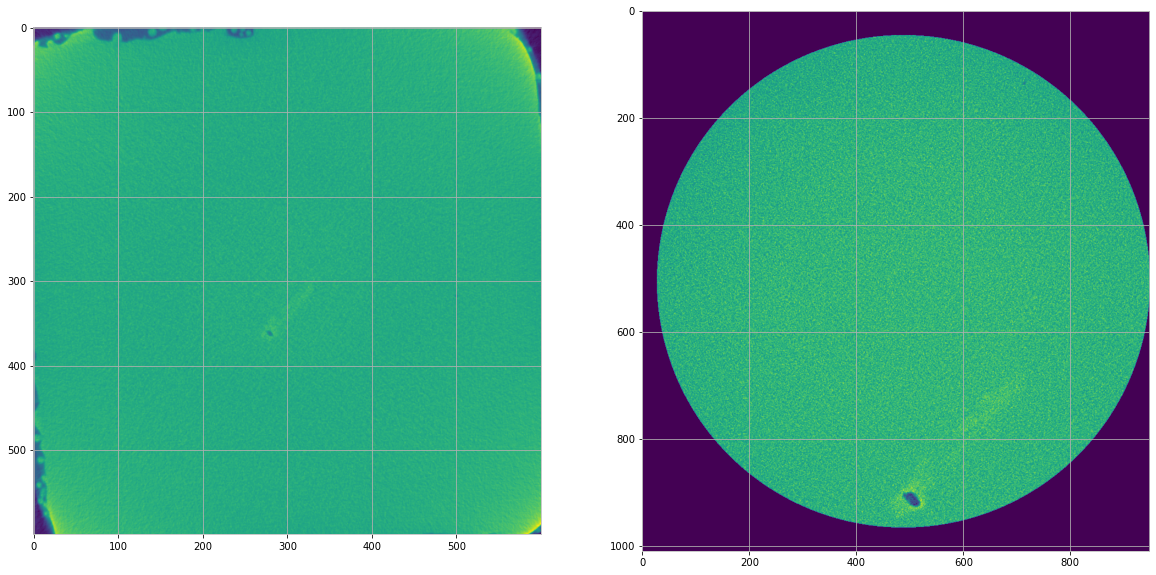

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(imageio.imread(high_res_files[436])[200:800, 200:800])
axes[1].imshow(imageio.imread(super_high_res_files[724]))

In [181]:
def overlap_images(small_img, big_img, top_left=(0, 0), mask=None, alpha=0, beta=1):
    w, h, *_ = small_img.shape
    top_left_x, top_left_y = top_left
    out = big_img.copy().astype('float32')
    if mask is None:
        out[top_left_x:top_left_x+w, top_left_y:top_left_y+h] = small_img
    else:
        out[top_left_x:top_left_x+w, top_left_y:top_left_y+h][mask] *= alpha
        out[top_left_x:top_left_x+w, top_left_y:top_left_y+h][mask] += small_img[mask] * beta
    return out

(244, 229)


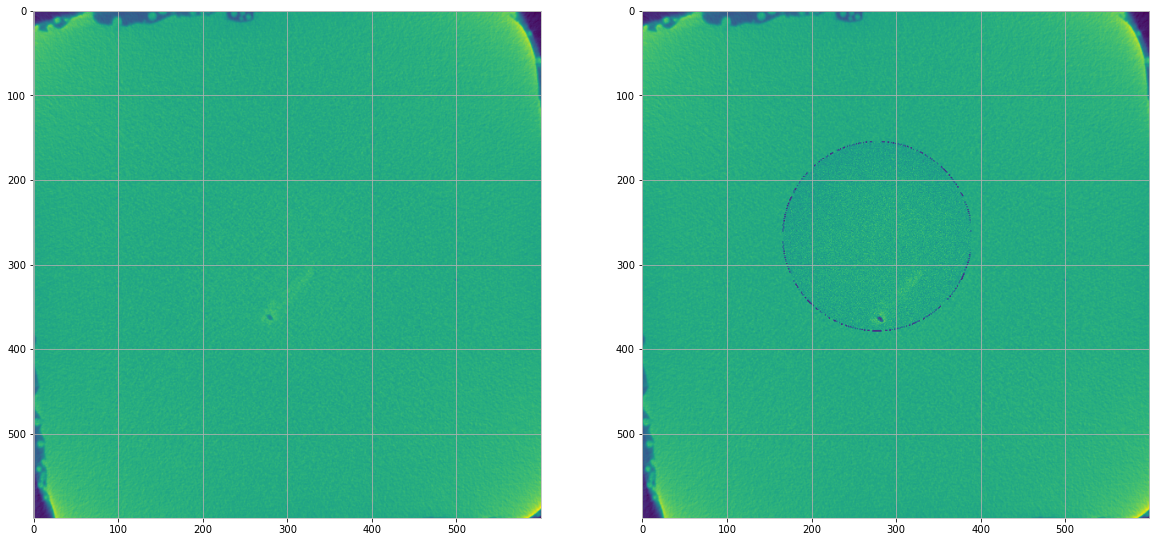

In [191]:
from scipy.ndimage import zoom
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
shr_ = zoom(imageio.imread(super_high_res_files[724]), .7/2.9)
print(shr_.shape)
hr_ = imageio.imread(high_res_files[436])[200:800, 200:800]
axes[0].imshow(hr_)
axes[1].imshow(overlap_images(shr_, hr_, top_left=(145, 160), mask=shr_!=0, alpha=.5, beta=.5))

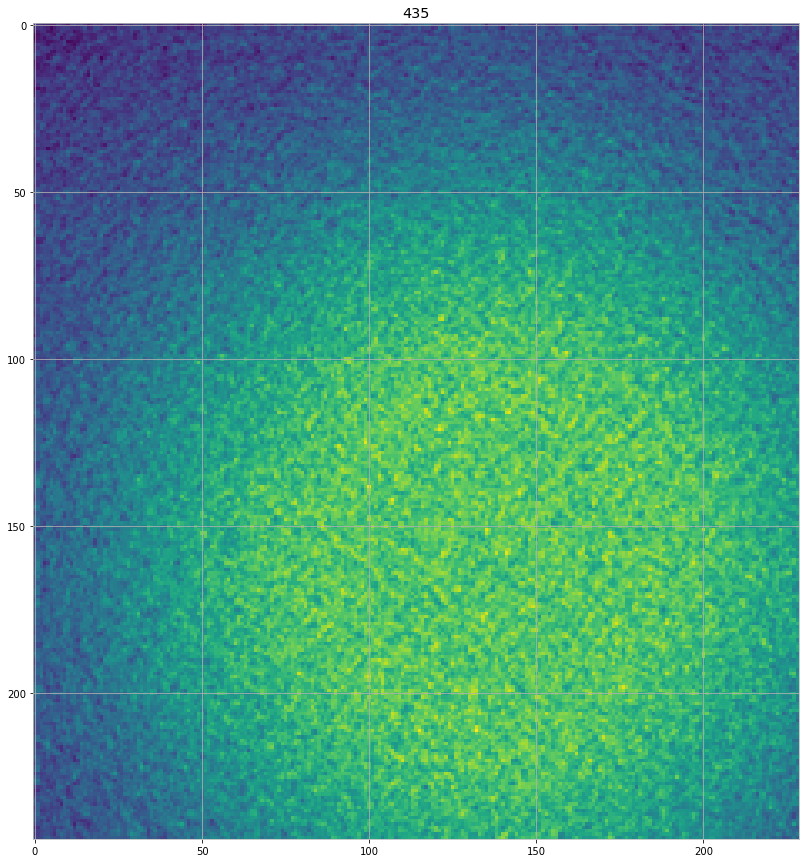

In [223]:
sleep_time = 1
start_index, end_index = 229, 436
show_image_list(
    (imageio.imread(x)[200:800, 200:800][145:145+244, 160:160+229] for x in high_res_files[start_index:end_index]), 
    sleep_time=sleep_time,  figsize=(15, 15), start_title_index=start_index
)

In [27]:
shr_ = min_max_scale(zoom(imageio.imread(super_high_res_files[724]), .7/2.9))
high_res_images = [delayed(lambda x: min_max_scale(imageio.imread(x)[200:800, 200:800]))(x) 
                   for x in high_res_files]
scores = [delayed(cv2.matchTemplate)(x, shr_, method=cv2.TM_CCORR_NORMED, mask=np.uint8(x!=0) for x in high_res_images]

In [28]:
scores = compute(scores)[0]

TypeError: mask data type = 0 is not supported

In [17]:
np.array(scores).shape

(997, 357, 372)

In [23]:
np.argmax(np.max(scores, axis=(1, 2)))

87

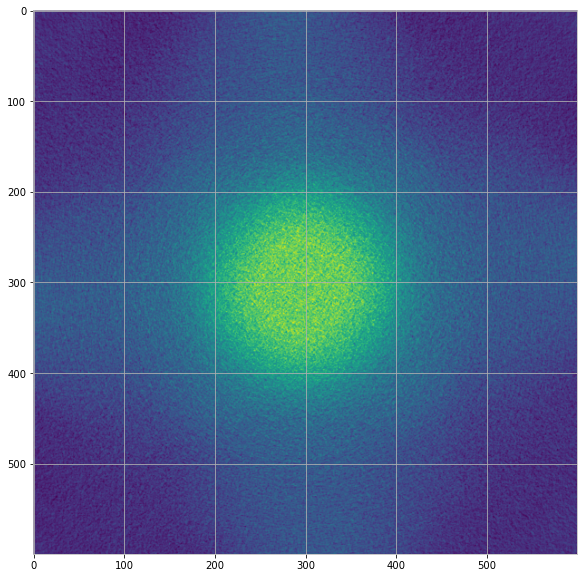

In [26]:
plt.imshow(imageio.imread(high_res_files[87])[200:800, 200:800])